# Libraries + References

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from fbprophet import Prophet

In [2]:
# https://www.kaggle.com/pinardogan/time-series-using-lightgbm-with-explanations
# https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/
# https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

# Read data

In [3]:
data_df = pd.read_csv("train.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data_df.head(5)
print(data_df.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [5]:
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df["Year"] = data_df.Date.dt.year
data_df["Month"] = data_df.Date.dt.month_name()
data_df["Week"] = data_df.Date.dt.week
data_df.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,July,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,July,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,July,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,July,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,July,31


# Training and Prediction for store 5

In [6]:
df_Store = data_df[data_df.Store == 5][["Date","Sales","Promo","StateHoliday","SchoolHoliday"]].reset_index().drop(columns="index")
df_Store.sort_values("Date",inplace=True)
df_Store.head(5)

,Date,Sales,Promo,StateHoliday,SchoolHoliday
941,2013-01-01,0,0,a,1
940,2013-01-02,4253,0,0,1
939,2013-01-03,3465,0,0,0
938,2013-01-04,4456,0,0,0
937,2013-01-05,1590,0,0,0


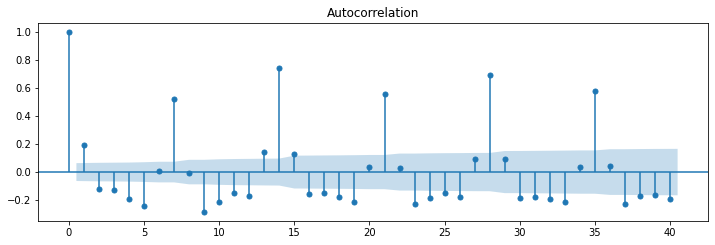

In [7]:
# Check for weekly seasonality 
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=40,ax=ax)

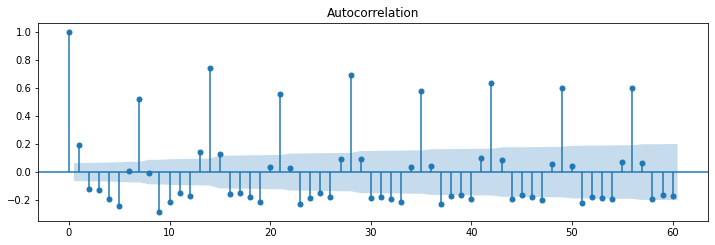

In [8]:
# Check for monthly
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=60,ax=ax)

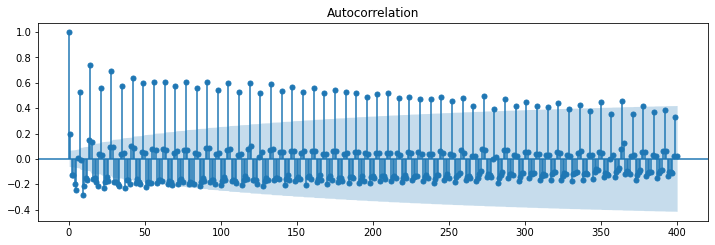

In [9]:
# Check for yearly seasonality
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(df_Store["Sales"],lags=400,ax=ax)

In [10]:
SalesSample = pd.DataFrame()
SalesSample['y'] = df_Store["Sales"]
SalesSample['ds'] = df_Store["Date"]
SalesSample['Promo'] = df_Store["Promo"]
SalesSample.head(10)

,y,ds,Promo
941,0,2013-01-01,0
940,4253,2013-01-02,0
939,3465,2013-01-03,0
938,4456,2013-01-04,0
937,1590,2013-01-05,0
936,0,2013-01-06,0
935,6978,2013-01-07,1
934,5718,2013-01-08,1
933,5974,2013-01-09,1
932,4999,2013-01-10,1


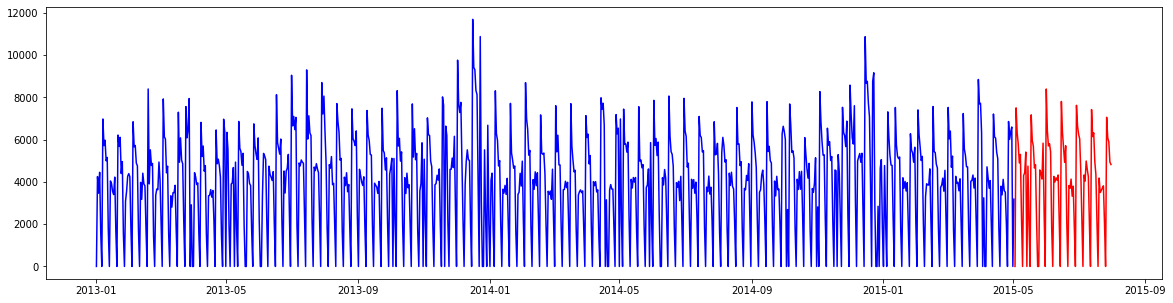

In [11]:
test_size = 90 # 3 months of data

train = SalesSample[:-test_size]
test = SalesSample[-test_size:]

plt.subplots(figsize=(20, 5))

plt.plot(train['ds'], train['y'],color='blue', label='Train')
plt.plot(test['ds'], test['y'], color='red', label='Test')

In [12]:
State_holidays = pd.DataFrame()
State_holidays["ds"] = df_Store[(df_Store.StateHoliday==1)]["Date"]
State_holidays["holiday"] = "State_Holiday"

School_holidays = pd.DataFrame()
School_holidays["ds"] = df_Store[(df_Store.SchoolHoliday==1)]["Date"]
School_holidays["holiday"] = "School_Holiday"

holidays = pd.concat([State_holidays, School_holidays])
holidays.sort_values("ds",inplace=True)
holidays.head(5)

,ds,holiday
941,2013-01-01,School_Holiday
940,2013-01-02,School_Holiday
907,2013-02-04,School_Holiday
906,2013-02-05,School_Holiday
905,2013-02-06,School_Holiday


In [13]:
model = Prophet(daily_seasonality=False,
weekly_seasonality=True,
yearly_seasonality=False,
holidays = holidays, seasonality_mode='additive')

model.add_regressor('Promo')

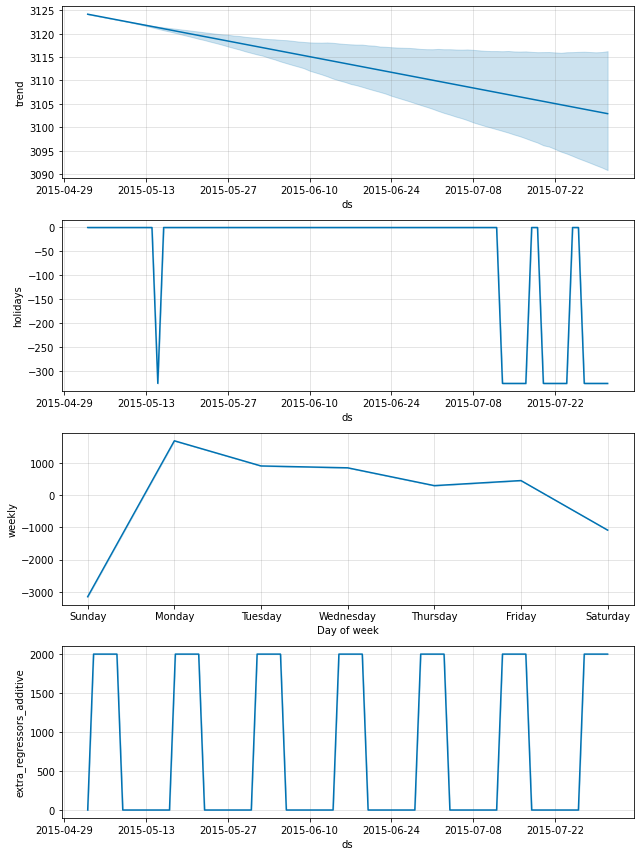

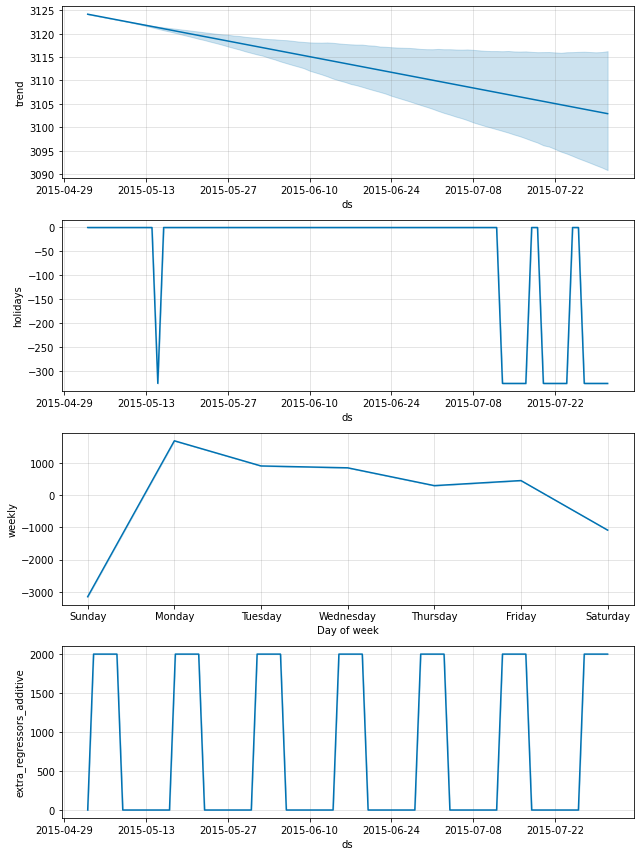

In [14]:
model.fit(train)
forecast = model.predict(test)
model.plot_components(forecast)

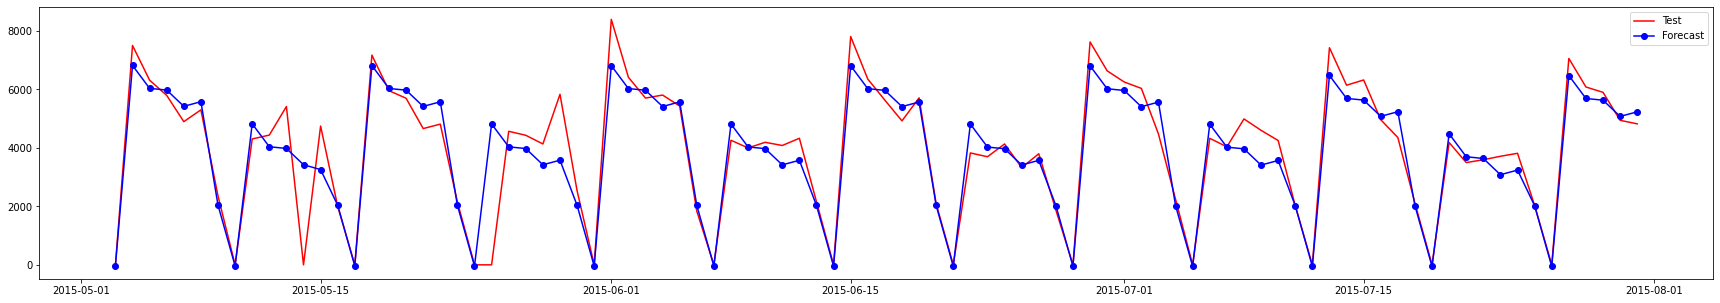

In [15]:
plt.figure(figsize=(30, 5))
plt.plot(test['ds'], test['y'], c='r', label='Test')
plt.plot(forecast['ds'], forecast['yhat'], c='blue', marker='o',label='Forecast')
plt.legend()
plt.show()

In [16]:
print("R2 score is: ",r2_score(test["y"],forecast['yhat']))

R2 score is:  0.8593549406647524
